Postgre Credentials

In [19]:
#Define These For Yourself
db_name = ""
user = ""
password = ""
host = ""
port = ""
table_name = "online_retail"
csv_file_path = "OnlineRetail.csv"

Imports

In [6]:
import pandas as pd
from sqlalchemy import create_engine, text
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

Reading CSV and setting up Data

In [7]:
df_csv = pd.read_csv(csv_file_path)
print("Data read from CSV (first 5 rows):")
print(df_csv.head())
print("Shape of df_csv:", df_csv.shape)

invoice_length = df_csv['InvoiceNo'].astype(str).apply(len).max()
stockcode_length = df_csv['StockCode'].astype(str).apply(len).max()
customer_ids = df_csv['CustomerID'].dropna().astype(int).astype(str)
customerid_length = customer_ids.apply(len).max()

invoice_varchar = max(20, invoice_length)
stock_varchar = max(20, stockcode_length)
customer_varchar = max(20, customerid_length)

df_csv['InvoiceDate'] = pd.to_datetime(df_csv['InvoiceDate'], format='%m/%d/%y %H:%M', errors='coerce')
print("Number of NaT in InvoiceDate:", df_csv['InvoiceDate'].isna().sum())

Data read from CSV (first 5 rows):
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

    InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/10 8:26       2.55     17850.0  United Kingdom  
1  12/1/10 8:26       3.39     17850.0  United Kingdom  
2  12/1/10 8:26       2.75     17850.0  United Kingdom  
3  12/1/10 8:26       3.39     17850.0  United Kingdom  
4  12/1/10 8:26       3.39     17850.0  United Kingdom  
Shape of df_csv: (541909, 8)
Number of NaT in InvoiceDate: 0


Connecting to Server and Loading Data into Postgre

In [8]:
engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{db_name}')
with engine.begin() as conn:
    conn.execute(text(f"DROP TABLE IF EXISTS {table_name};"))
    conn.execute(text(f"""
    CREATE TABLE {table_name} (
        "InvoiceNo" VARCHAR({invoice_varchar}),
        "StockCode" VARCHAR({stock_varchar}),
        "Description" TEXT,
        "Quantity" INT,
        "InvoiceDate" TIMESTAMP,
        "UnitPrice" NUMERIC(10,4),
        "CustomerID" VARCHAR({customer_varchar}),
        "Country" VARCHAR(50)
    );
    """))
    conn.execute(text(f"TRUNCATE {table_name};"))

print("Table created and truncated successfully.")

df_csv.to_sql(table_name, engine, if_exists='append', index=False, method='multi')
print("Data loaded into Postgres.")

df = pd.read_sql(f"SELECT * FROM {table_name};", engine)
print("Data read back (first 5 rows):")
print(df.head())
print("Shape of df:", df.shape)

Table created and truncated successfully.
Data loaded into Postgres.
Data read back (first 5 rows):
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
Shape of df: (541909, 8)


Preprocessing Data for Recency, Frequency, and Monetary Value

In [9]:
df = df.dropna(subset=['CustomerID'])  # remove rows without CustomerID
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
snapshot_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Quantity': lambda x: (x * df.loc[x.index, 'UnitPrice']).sum()
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Quantity': 'MonetaryValue'
}, inplace=True)

print("RFM (first 5 rows):")
print(rfm.head())

RFM (first 5 rows):
  CustomerID  Recency  Frequency  MonetaryValue
0    12346.0      325          2           0.00
1    12347.0        1          7        4310.00
2    12348.0       74          4        1797.24
3    12349.0       18          1        1757.55
4    12350.0      309          1         334.40


Creating Elbow Method Graph

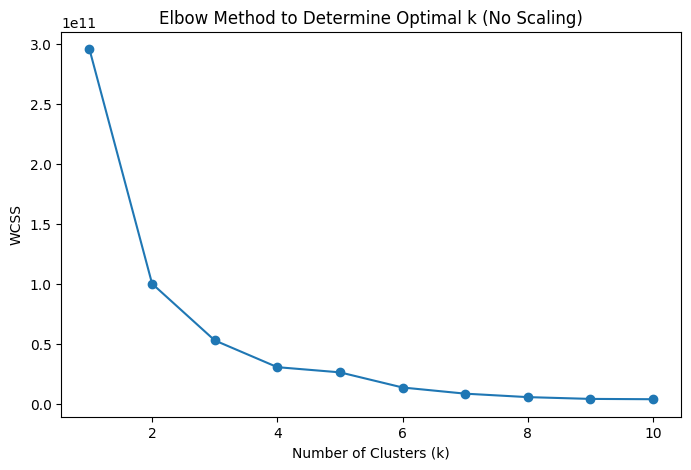

In [10]:
features = rfm[['Recency', 'Frequency', 'MonetaryValue']]

wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method to Determine Optimal k (No Scaling)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

Clustering

In [11]:
kmeans_no_scaling = KMeans(n_clusters=5, random_state=42)
kmeans_no_scaling.fit(features)
rfm['Cluster_NoScaling'] = kmeans_no_scaling.labels_

cluster_profiles_no_scale = rfm.groupby('Cluster_NoScaling').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
})

print("Cluster Profiles (No Scaling):")
print(cluster_profiles_no_scale)


Cluster Profiles (No Scaling):
                     Recency  Frequency  MonetaryValue
Cluster_NoScaling                                     
0                  91.840841   4.570109    1347.622983
1                   7.000000  55.000000  187482.170000
2                  12.138889  50.722222   35694.129167
3                   8.500000  96.500000  114451.897500
4                   0.500000  69.500000  267963.755000


Plotting the Clusters

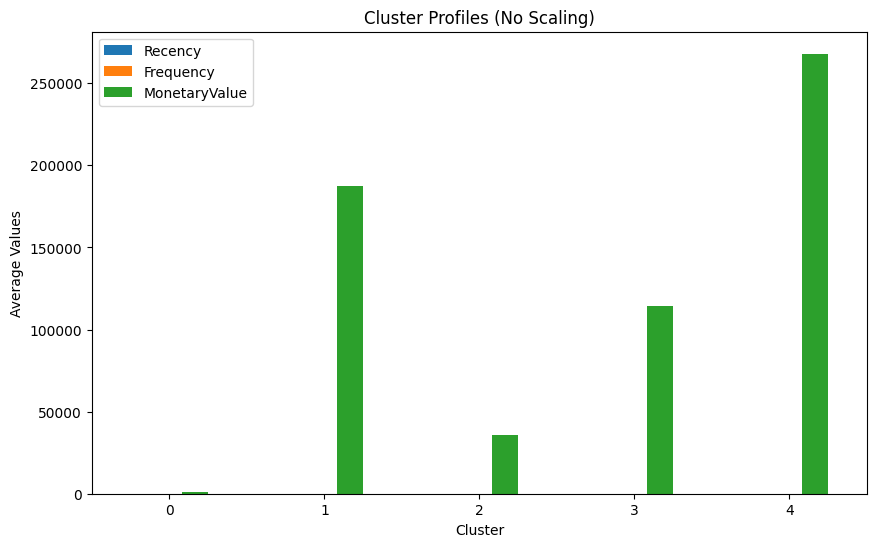

In [12]:
cluster_profiles_no_scale.plot(kind='bar', figsize=(10,6))
plt.title('Cluster Profiles (No Scaling)')
plt.xlabel('Cluster')
plt.ylabel('Average Values')
plt.xticks(rotation=0)
plt.show()

Scaling the Data

In [13]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_rfm = pd.DataFrame(scaled_features, columns=['Recency', 'Frequency', 'MonetaryValue'])

Clustering

In [14]:
kmeans_model = KMeans(n_clusters=5, random_state=42)
kmeans_model.fit(scaled_rfm)
rfm['Cluster'] = kmeans_model.labels_

print("Cluster assignments with scaling:")
print(rfm[['CustomerID', 'Cluster']].head())

cluster_profiles = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
})

print("Cluster Profiles (With Scaling):")
print(cluster_profiles)

Cluster assignments with scaling:
  CustomerID  Cluster
0    12346.0        1
1    12347.0        3
2    12348.0        3
3    12349.0        3
4    12350.0        1
Cluster Profiles (With Scaling):
            Recency  Frequency  MonetaryValue
Cluster                                      
0         13.849315  19.652055    7095.058137
1        249.284102   1.799624     454.581384
2          5.181818  88.363636   54540.575909
3         43.813635   3.756766    1131.842149
4          2.666667  64.666667  241136.560000


Plotting the Scaled Clusters

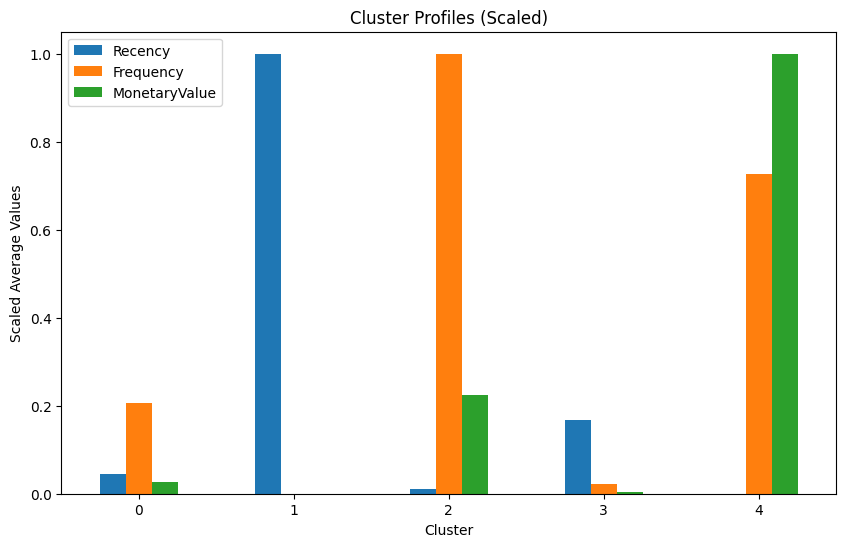

In [15]:
minmax_scaler = MinMaxScaler()
scaled_values = minmax_scaler.fit_transform(cluster_profiles[['Recency', 'Frequency', 'MonetaryValue']])
cluster_profiles_scaled = pd.DataFrame(scaled_values,
                                       columns=['Recency', 'Frequency', 'MonetaryValue'],
                                       index=cluster_profiles.index)

cluster_profiles_scaled.plot(kind='bar', figsize=(10,6))
plt.title('Cluster Profiles (Scaled)')
plt.xlabel('Cluster')
plt.ylabel('Scaled Average Values')
plt.xticks(rotation=0)
plt.show()

Training K-Nearest Neighbor Model on the Clusters

In [16]:
X_train = scaled_rfm.values 
y_train = rfm['Cluster'].values 

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)


KNeighborsClassifier(weights='distance')

Creating Synthetic Data

In [17]:
synthetic_points = pd.DataFrame({
    'Recency': [10, 50, 90],
    'Frequency': [2, 15, 7],
    'MonetaryValue': [100, 1000, 500]
})

print("\nSynthetic Points:")
print(synthetic_points)


Synthetic Points:
   Recency  Frequency  MonetaryValue
0       10          2            100
1       50         15           1000
2       90          7            500


Scaling Data And Making Predictions

In [18]:
synthetic_scaled = scaler.transform(synthetic_points[['Recency', 'Frequency', 'MonetaryValue']])

predicted_clusters = knn.predict(synthetic_scaled)

print("\nPredicted cluster for each synthetic point:")
print(predicted_clusters)


Predicted cluster for each synthetic point:
[3 0 3]
